In [169]:
from sklearn.model_selection import train_test_split
from apscheduler.schedulers.background import BackgroundScheduler
from apscheduler.schedulers.blocking import BlockingScheduler
from influxdb_client.client.write_api import SYNCHRONOUS
from influxdb_client import InfluxDBClient
from dotenv import load_dotenv
import pandas as pd
import datetime
import os

In [170]:
# InfluxDB 접속 정보 불러오기
load_dotenv('secret.env')

DB_URL=os.getenv('DB_URL')
DB_TOKEN=os.getenv('DB_TOKEN')
DB_ORG=os.getenv('DB_ORG')
DB_BUCKET=os.getenv('DB_BUCKET')

In [171]:
# InfluxDB에서 주어진 측정치에 대한 데이터를 조회하여 DataFrame으로 반환.
def query_influx(measurement):
    client = InfluxDBClient(url=DB_URL, token=DB_TOKEN, org=DB_ORG, timeout=30_000)
    query_api = client.query_api()
    
    query = f'''
    import "date"
    import "influxdata/influxdb/schema"
    from(bucket: "{DB_BUCKET}")
      |> range(start: date.sub(d: 7d, from: date.truncate(t: now(), unit: 1d)), stop: now())
      |> filter(fn: (r) => r["_measurement"] == "{measurement}")
      |> schema.fieldsAsCols()
    '''
    
    result_df = query_api.query_data_frame(org=DB_ORG, query=query)
    print(f"{measurement} shape: ", result_df.shape)
    
    client.close()
    return result_df

temperature_df = query_influx("temperature")
humidity_df = query_influx("humidity")
people_count_df = query_influx("total_people_count")
magnet_status_df = query_influx("magnet_status")


temperature shape:  (11858, 10)
humidity shape:  (11659, 10)
total_people_count shape:  (2723, 10)
magnet_status shape:  (171, 10)


In [172]:
# class A에 있는 센서값만 보도록 수정
temperature_class_a_df = temperature_df[temperature_df['place'] == 'class_a']
humidity_class_a_df = humidity_df[humidity_df['place'] == 'class_a']

# 필요없는 컬럼 삭제 및 한국시간으로 설정
temperature_class_a_df = temperature_class_a_df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
temperature_class_a_df['_time'] = temperature_class_a_df['_time'].dt.tz_convert('Asia/Seoul')
temperature_class_a_df['_time'] = pd.to_datetime(temperature_class_a_df._time).dt.tz_localize(None)

humidity_class_a_df = humidity_class_a_df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
humidity_class_a_df['_time'] = humidity_class_a_df['_time'].dt.tz_convert('Asia/Seoul')
humidity_class_a_df['_time'] = pd.to_datetime(humidity_class_a_df._time).dt.tz_localize(None)

people_count_df = people_count_df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
people_count_df['_time'] = people_count_df['_time'].dt.tz_convert('Asia/Seoul')
people_count_df['_time'] = pd.to_datetime(people_count_df._time).dt.tz_localize(None)

magnet_status_df = magnet_status_df.drop(columns=['_start', '_stop', 'result', 'table', 'topic', 'device'])
magnet_status_df['_time'] = magnet_status_df['_time'].dt.tz_convert('Asia/Seoul')
magnet_status_df['_time'] = pd.to_datetime(magnet_status_df._time).dt.tz_localize(None)


In [173]:
print("info : ", temperature_class_a_df.head())
print("info : ", humidity_class_a_df.head())
print("info : ", people_count_df.head())
print("info : ", magnet_status_df.head())

info :                          _time _measurement    place      value
0  2024-04-19 14:43:51.540435  temperature  class_a  24.299999
2  2024-04-19 14:45:25.074113  temperature  class_a  23.400000
6  2024-04-19 14:45:49.959823  temperature  class_a  24.400000
8  2024-04-19 14:46:10.411416  temperature  class_a  24.200001
12 2024-04-19 14:46:49.685429  temperature  class_a  24.400000
info :                          _time _measurement    place  value
0  2024-04-19 14:43:50.374828     humidity  class_a   42.5
2  2024-04-19 14:45:25.066652     humidity  class_a   49.0
6  2024-04-19 14:45:49.950731     humidity  class_a   43.0
8  2024-04-19 14:46:10.424577     humidity  class_a   45.5
12 2024-04-19 14:46:49.699407     humidity  class_a   42.5
info :                         _time        _measurement    place  value
0 2024-04-19 14:43:46.166698  total_people_count  class_a    9.0
1 2024-04-19 14:45:10.564579  total_people_count  class_a    8.0
2 2024-04-19 14:45:39.585428  total_people_count 

In [174]:
# resample로 합치려면 Datetime을 인덱스로 지정
temperature_class_a_df.set_index('_time', inplace=True)
humidity_class_a_df.set_index('_time', inplace=True)
people_count_df.set_index('_time', inplace=True)
magnet_status_df.set_index('_time', inplace=True)

# value에 대해 1분 단위로 평균 or 마지막값 계산. resample을 수행한 후에는 Series 객체가 됨.
temperature_summary_series = temperature_class_a_df['value'].resample('T').mean()
humidity_summary_series = humidity_class_a_df['value'].resample('T').mean()
people_count_series = people_count_df['value'].resample('T').last()
magnet_status_series = magnet_status_df['value'].resample('T').last()

print(temperature_summary_series)
print(humidity_summary_series)
print(people_count_series)
print(magnet_status_series)

_time
2024-04-19 14:43:00    24.299999
2024-04-19 14:44:00          NaN
2024-04-19 14:45:00    23.900000
2024-04-19 14:46:00    24.300000
2024-04-19 14:47:00    24.080000
                         ...    
2024-04-20 19:03:00    24.200000
2024-04-20 19:04:00    24.033333
2024-04-20 19:05:00    24.200000
2024-04-20 19:06:00    24.066666
2024-04-20 19:07:00    23.900000
Freq: T, Name: value, Length: 1705, dtype: float64
_time
2024-04-19 14:43:00    42.500000
2024-04-19 14:44:00          NaN
2024-04-19 14:45:00    46.000000
2024-04-19 14:46:00    44.000000
2024-04-19 14:47:00    45.300000
                         ...    
2024-04-20 19:03:00    46.750000
2024-04-20 19:04:00    47.666667
2024-04-20 19:05:00    46.750000
2024-04-20 19:06:00    47.666667
2024-04-20 19:07:00    48.000000
Freq: T, Name: value, Length: 1705, dtype: float64
_time
2024-04-19 14:43:00    9.0
2024-04-19 14:44:00    NaN
2024-04-19 14:45:00    7.0
2024-04-19 14:46:00    9.0
2024-04-19 14:47:00    9.0
                   

In [175]:
data_df = pd.DataFrame({
    'temperature': temperature_summary_series,
    'humidity': humidity_summary_series,
    'people_count': people_count_series,
    'air_conditional': magnet_status_series
})

print(data_df)
print(data_df.info())

                     temperature   humidity  people_count air_conditional
_time                                                                    
2024-04-19 14:43:00    24.299999  42.500000           9.0             NaN
2024-04-19 14:44:00          NaN        NaN           NaN             NaN
2024-04-19 14:45:00    23.900000  46.000000           7.0             NaN
2024-04-19 14:46:00    24.300000  44.000000           9.0             NaN
2024-04-19 14:47:00    24.080000  45.300000           9.0             NaN
...                          ...        ...           ...             ...
2024-04-20 19:03:00    24.200000  46.750000           0.0             NaN
2024-04-20 19:04:00    24.033333  47.666667           0.0             NaN
2024-04-20 19:05:00    24.200000  46.750000           0.0             NaN
2024-04-20 19:06:00    24.066666  47.666667           0.0             NaN
2024-04-20 19:07:00    23.900000  48.000000           NaN             NaN

[1705 rows x 4 columns]
<class 'panda

In [176]:
# 결측치 처리
null_values = data_df.isnull().sum()
print(null_values)

# 센서값 측정 시간상 해당 시간에 값이 없을 수도 있으므로 채워주기.
if pd.isna(data_df.loc[data_df.index[0], 'air_conditional']):
    data_df.at[data_df.index[0], 'air_conditional'] = 'close'


# peoplecount에서 not null인 값 중 가장 최근값
notnull_peoplecount = data_df[data_df['people_count'].notnull()].iloc[0]['people_count']

if pd.isna(data_df.loc[data_df.index[0], 'people_count']):
    data_df.at[data_df.index[0], 'people_count'] = notnull_peoplecount

data_df_filled = data_df.fillna(method='ffill', axis=0)

print(data_df_filled.isnull().sum())

temperature           1
humidity              1
people_count         23
air_conditional    1534
dtype: int64
temperature        0
humidity           0
people_count       0
air_conditional    0
dtype: int64


In [177]:
print(data_df_filled.info)
print(data_df_filled)
print(data_df_filled.shape)

<bound method DataFrame.info of                      temperature   humidity  people_count air_conditional
_time                                                                    
2024-04-19 14:43:00    24.299999  42.500000           9.0           close
2024-04-19 14:44:00    24.299999  42.500000           9.0           close
2024-04-19 14:45:00    23.900000  46.000000           7.0           close
2024-04-19 14:46:00    24.300000  44.000000           9.0           close
2024-04-19 14:47:00    24.080000  45.300000           9.0           close
...                          ...        ...           ...             ...
2024-04-20 19:03:00    24.200000  46.750000           0.0           close
2024-04-20 19:04:00    24.033333  47.666667           0.0           close
2024-04-20 19:05:00    24.200000  46.750000           0.0           close
2024-04-20 19:06:00    24.066666  47.666667           0.0           close
2024-04-20 19:07:00    23.900000  48.000000           0.0           close

[1705

In [178]:
data_df_filled.index = data_df_filled.index.time
print(data_df_filled)
print(data_df_filled.info())

          temperature   humidity  people_count air_conditional
14:43:00    24.299999  42.500000           9.0           close
14:44:00    24.299999  42.500000           9.0           close
14:45:00    23.900000  46.000000           7.0           close
14:46:00    24.300000  44.000000           9.0           close
14:47:00    24.080000  45.300000           9.0           close
...               ...        ...           ...             ...
19:03:00    24.200000  46.750000           0.0           close
19:04:00    24.033333  47.666667           0.0           close
19:05:00    24.200000  46.750000           0.0           close
19:06:00    24.066666  47.666667           0.0           close
19:07:00    23.900000  48.000000           0.0           close

[1705 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>
Index: 1705 entries, 14:43:00 to 19:07:00
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   temperatur

In [179]:
# air_conditional의 값이 close면 0, open이면 1로 변경

data_df_filled['air_conditional'] = data_df_filled['air_conditional'].map({'close': 0, 'open': 1})

In [180]:
print(data_df_filled)
print(data_df_filled.info)

          temperature   humidity  people_count  air_conditional
14:43:00    24.299999  42.500000           9.0                0
14:44:00    24.299999  42.500000           9.0                0
14:45:00    23.900000  46.000000           7.0                0
14:46:00    24.300000  44.000000           9.0                0
14:47:00    24.080000  45.300000           9.0                0
...               ...        ...           ...              ...
19:03:00    24.200000  46.750000           0.0                0
19:04:00    24.033333  47.666667           0.0                0
19:05:00    24.200000  46.750000           0.0                0
19:06:00    24.066666  47.666667           0.0                0
19:07:00    23.900000  48.000000           0.0                0

[1705 rows x 4 columns]
<bound method DataFrame.info of           temperature   humidity  people_count  air_conditional
14:43:00    24.299999  42.500000           9.0                0
14:44:00    24.299999  42.500000           9.0 

In [181]:
# 상관계수 계산
correlation_matrix = data_df_filled.corr()
print(correlation_matrix)

                 temperature  humidity  people_count  air_conditional
temperature         1.000000  0.356141      0.426901        -0.180536
humidity            0.356141  1.000000      0.185779         0.022146
people_count        0.426901  0.185779      1.000000         0.533734
air_conditional    -0.180536  0.022146      0.533734         1.000000


/home/gahyoung/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


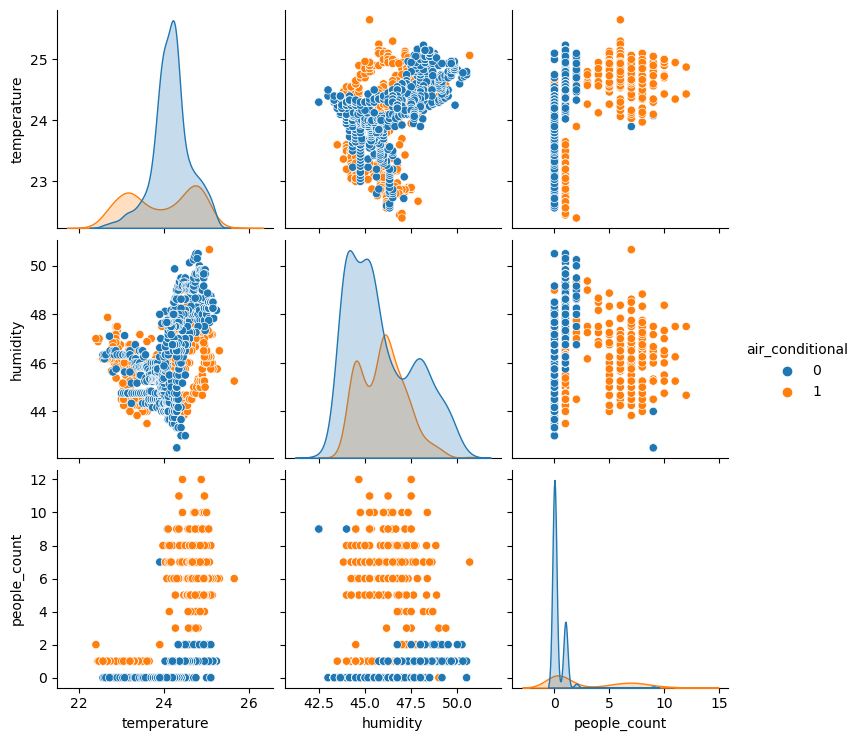

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns

# 산점도 그리기
sns.pairplot(data_df_filled, hue='air_conditional', vars=['temperature', 'humidity', 'people_count'])
plt.show()

In [183]:
# 훈련데이터와 테스트 데이터 분리
X = data_df_filled[['temperature', 'humidity', 'people_count']]
y = data_df_filled['air_conditional']

# # 데이터를 훈련 세트와 테스트 세트로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [184]:
# 로지스틱 회귀
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 데이터 준비: X는 온도와 습도, y는 에어컨의 ON/OFF 상태
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 생성 및 학습
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train, y_train)

# 모델 평가
from sklearn.metrics import accuracy_score
log_reg_predictions = log_reg_model.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
print("LogisticRegression Accuracy:", log_reg_accuracy)

LogisticRegression Accuracy: 0.8621700879765396


In [185]:
# 랜덤 포레스트
from sklearn.ensemble import RandomForestClassifier

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# 예측 및 성능 평가
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("RandomForest Accuracy:", rf_accuracy)

RandomForest Accuracy: 0.9149560117302052


In [186]:
# XG 부스트
import xgboost as xgb

# 데이터 준비
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 생성 및 학습
xgboost_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgboost_model.fit(X_train, y_train)

# 예측 및 성능 평가
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_accuracy = accuracy_score(y_test, xgboost_predictions)
print("XGBoost Accuracy:", xgboost_accuracy)

XGBoost Accuracy: 0.9237536656891495


In [187]:
print(y.value_counts())

0    1181
1     524
Name: air_conditional, dtype: int64


In [188]:
from sklearn.metrics import classification_report

print(classification_report(y_test, log_reg_predictions))
print(classification_report(y_test, rf_predictions))
print(classification_report(y_test, xgboost_predictions))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       226
           1       0.87      0.70      0.77       115

    accuracy                           0.86       341
   macro avg       0.86      0.82      0.84       341
weighted avg       0.86      0.86      0.86       341

              precision    recall  f1-score   support

           0       0.91      0.96      0.94       226
           1       0.92      0.82      0.87       115

    accuracy                           0.91       341
   macro avg       0.92      0.89      0.90       341
weighted avg       0.92      0.91      0.91       341

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       226
           1       0.93      0.83      0.88       115

    accuracy                           0.92       341
   macro avg       0.93      0.90      0.91       341
weighted avg       0.92      0.92      0.92       341

